<center><h1>Automatic Differentiation with Autograd</h1></center>

In this tutorial, we'll explore how PyTorch's autograd system eliminates the need for manually defining gradients for our complex operations by automatically calculating them. Additionally, we will delve into the torch.nn module, which offers a suite of pre-built deep learning layers, and learn how to construct a Multilayer Perceptron (MLP) utilizing this toolkit.

You can read this page: https://en.wikipedia.org/wiki/Automatic_differentiation

After this practical, you have to read this one from pytorch: https://pytorch.org/tutorials/beginner/introyt/autogradyt_tutorial.html

In [1]:
%matplotlib inline

import torch
import numpy as np
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

Min and max value: 0.0, 1.0
Flatenned images shape: torch.Size([1797, 64])


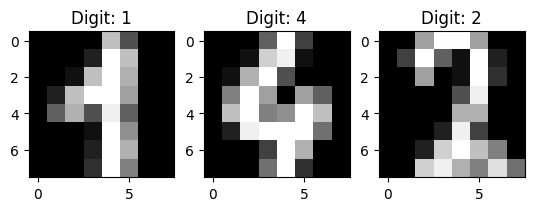

In [2]:
digits = load_digits()
X = torch.tensor(digits["images"]).float()
Y = torch.tensor(digits["target"]).long()

plt.subplot(1, 3, 1)
plt.imshow(X[42], cmap="gray")
plt.title(f"Digit: {Y[42]}");

plt.subplot(1, 3, 2)
plt.imshow(X[64], cmap="gray")
plt.title(f"Digit: {Y[64]}");

plt.subplot(1, 3, 3)
plt.imshow(X[1337], cmap="gray")
plt.title(f"Digit: {Y[1337]}");

X = X / X.max()
print(f"Min and max value: {X.min()}, {X.max()}")

X = X.view(X.shape[0], -1)
print(f"Flatenned images shape: {X.shape}")

## Autograd Guide


In PyTorch, tensors have two main properties: `requires_grad` and `grad`. The `requires_grad` attribute indicates whether gradients should be calculated for the tensor, allowing for automatic differentiation during neural network training. Meanwhile, the grad attribute stores the gradients themselves once they've been computed.

By default, `requires_grad` is set to false, which is suitable for situations where gradient computation is unnecessary. Examples include:

Tensors representing image pixels, which are data inputs rather than parameters to be optimized.
Tensors or model weights that should remain constant during training, also known as "frozen" parameters.
Here's a simple illustration using the square function:

For the function $f(x) = x^2$, its derivative $f'(x) = 2x$.

Therefore, for $x = 4$, $f(4) = 16$ and $f'(4) = 8$.

In [3]:
x = torch.tensor(4., requires_grad=True)

def f(x):
  return x ** 2

y = f(x)
print(f"x={x}, f({x})={y}")

# We ask autograd to "backward" the gradients up to the start
y.backward()

print(f"x={x}, f'({x})={x.grad}")

x=4.0, f(4.0)=16.0
x=4.0, f'(4.0)=8.0


Let's create a more complex function for your students to work with. We'll use a polynomial function as the example, which introduces a mix of operations and is more complex than the simple square function. The chosen function will be:

f(x) = 3x^3 - 2x^2 + 4x - 5

This function involves cubic and quadratic terms, as well as linear and constant terms, making it a good candidate for a more challenging exercise on calculating gradients.

In [ ]:
# FIXME

It's important to understand that, in PyTorch, the backward method is typically applied to scalar values (single numbers) by default, rather than tensors (vectors, matrices, and so on). This is a unique aspect of PyTorch's design.

Below, you'll find two examples illustrating approaches to accommodate this characteristic:

In [5]:
x = torch.tensor([1., 4., 2.], requires_grad=True)
(x ** 2).sum().backward()
print(f"Gradients: {x.grad}")

x = torch.tensor([1., 4., 2.], requires_grad=True)
(x ** 2).backward(torch.tensor([1, 1, 1]))
print(f"Gradients: {x.grad}")

Gradients: tensor([2., 8., 4.])
Gradients: tensor([2., 8., 4.])


Now let's take the formulas of a fully connected layer with 1 output:

$\mathbf{x} \in \mathbb{R^n}$, $\mathbf{W} \in \mathbb{R^{n}}$, and $\mathbf{b} \in \mathbb{R}$:

$\mathbf{h} = \mathbf{W}\mathbf{x} + \mathbf{b}$

... and code it in pytorch! What are gradients w.r.t the weights $\mathbf{W}$ and $\mathbf{b}$ according to you? Check it with autograd.

In [6]:
n = 2
w = torch.randn(n, requires_grad=True)
b = torch.randn(1, requires_grad=True)
x = torch.randn(n)

h = torch.dot(w, x) + b
h.backward()

print(f"x is\n {x}")
print(f"grad W is\n {w.grad}")
print(f"grad b is\n {b.grad}")

x is
 tensor([0.3691, 0.3334])
grad W is
 tensor([0.3691, 0.3334])
grad b is
 tensor([1.])


That's right, $\nabla_\mathbf{W} \mathcal{L} = \mathbf{x}$ and $\nabla_\mathbf{b} \mathcal{L} = 1$. But what happens if our layer has not 1 outputs but $m$ with $\mathbf{W} \in \mathbb{R^{m \times n}}$, and $\mathbf{b} \in \mathbb{R^{m}}$?

In [7]:
n, m = 2, 3

w = torch.randn(m, n, requires_grad=True)
b = torch.randn(m, requires_grad=True)
x = torch.randn(n)

# torch.mv for "Matrix-Vector product"
h = torch.mv(w, x) + b
h.sum().backward()

print(f"x is\n {x}")
print(f"grad W is\n {w.grad}")
print(f"grad b is\n {b.grad}")

x is
 tensor([-0.8203,  0.2338])
grad W is
 tensor([[-0.8203,  0.2338],
        [-0.8203,  0.2338],
        [-0.8203,  0.2338]])
grad b is
 tensor([1., 1., 1.])


$\nabla_\mathbf{W} \mathcal{L}$ is simply $\mathbf{x}$ stacked $m$ times. Which can do with an outer product:

In [8]:
torch.outer(torch.tensor([1., 1., 1.]), x)

tensor([[-0.8203,  0.2338],
        [-0.8203,  0.2338],
        [-0.8203,  0.2338]])

Equivalent to:

In [9]:
torch.mm(torch.ones(3, 1), x[:, None].T)

tensor([[-0.8203,  0.2338],
        [-0.8203,  0.2338],
        [-0.8203,  0.2338]])

In simpler terms, this implies that every element of the vector $(\mathbf{x})$ has an equal impact on every output dimension produced by the fully connected layer.

Next, we will introduce an additional dimension to $(\mathbf{x})$, making it $(\mathbf{x} \in \mathbb{R}^{k \times n})$, where $(k)$ stands for the **batch size**, which refers to the number of samples processed together in a single forward and backward pass. If unsure, examining the dimensions of each tensor can guide you on how to implement this change.

In [10]:
k, n, m = 4, 2, 3

w = torch.randn(n, m, requires_grad=True)
b = torch.randn(m, requires_grad=True)
x = torch.randn(k, n)

h = torch.mm(x, w) + b
print(f"Output shape is {h.shape}")
h.sum().backward()

print(f"x is\n {x}")
print(f"grad W is\n {w.grad}")
print(f"grad b is\n {b.grad}")

Output shape is torch.Size([4, 3])
x is
 tensor([[ 0.0891,  0.8598],
        [-1.1591,  0.3141],
        [-2.8186,  0.0817],
        [ 0.3229, -0.4308]])
grad W is
 tensor([[-3.5656, -3.5656, -3.5656],
        [ 0.8247,  0.8247,  0.8247]])
grad b is
 tensor([4., 4., 4.])


Notice that, now, we do a matrix multiplication between $\mathbf{X}$ on the left, and $\mathbf{W}$ on the right. Intuitively we don't want to change the batch size $k$ dimension of the inputs, but only the features dimension $n$.

Now the values of $\nabla_\mathbf{W} \mathcal{L}$ and $\nabla_\mathbf{b} \mathcal{L}$ are dependent on the batch size $k$. Which is why we usually normalize both gradients by $k$:

In [11]:
print(f"Mean of x alongside the batch dimension (first one) is\n {x.mean(dim=0)}")
print(f"Normalized w grad is\n {w.grad / k}")
print(f"Normalized b grad is\n {b.grad / k}")

Mean of x alongside the batch dimension (first one) is
 tensor([-0.8914,  0.2062])
Normalized w grad is
 tensor([[-0.8914, -0.8914, -0.8914],
        [ 0.2062,  0.2062,  0.2062]])
Normalized b grad is
 tensor([1., 1., 1.])


## MLP with autograd

In this section, we'll revisit the Multilayer Perceptron (MLP) and adapt it to utilize PyTorch's autograd for the backward pass. This adjustment mainly involves how we handle the model's parameters.

We've encapsulated the model's weights and biases within a Parameter class. This encapsulation automatically sets the tensors to require gradients, along with other functionalities.

Key Point: When it's time to update the parameters like weights and biases, make sure to alter their data attribute instead of the tensor itself. This distinction is crucial because PyTorch tracks operations on tensors that need gradients for autograd to calculate the necessary backpropagation steps. However, this tracking is unnecessary for the parameter update process.

Here's how you should and shouldn't update parameters:

Incorrect way (will track operations unnecessarily):

```python
new_w = old_w - lr * gradient  # Bad

new_w.data = old_w.data - lr * gradient  # Good
```

In [12]:
def softmax(x: torch.Tensor) -> torch.Tensor:
    # Implement softmax function
    # FIXME
    return None

def cross_entropy(probs: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    # Implement cross entropy
    # FIXME
    return None

In [50]:
from torch.nn import Parameter

class MLP:
    def __init__(self, input_size: int, hidden_size: int, nb_classes: int, learning_rate: float = 0.01):
        self.w_hidden = Parameter(torch.randn(input_size, hidden_size).float())
        self.b_hidden = Parameter(torch.zeros(hidden_size).float())

        self.w_output = Parameter(torch.randn(hidden_size, nb_classes).float())
        self.b_output = Parameter(torch.zeros(nb_classes).float())

        self.learning_rate = learning_rate

    def forward(self, x: torch.Tensor):
        # Use torch.mm and torch.tanh
        h_tilde = torch.mm(x, self.w_hidden) + self.b_hidden
        h = torch.tanh(h_tilde)
        logits = torch.mm(h, self.w_output) + self.b_output

        return logits, h_tilde, h

    def fit(self, inputs: torch.Tensor, targets: torch.Tensor, train: bool = True):
        logits, *outputs = self.forward(inputs)
        probs = softmax(logits)
        loss = cross_entropy(probs, torch.eye(10)[targets]).mean()
        if train:
            self.backward(inputs, probs, targets, loss)
        return loss

    def backward(self, inputs: torch.Tensor, probs: torch.Tensor, targets: torch.Tensor, loss: float):
        batch_size = len(probs)

        loss.backward()  # Fill the graph with .grad attributes

        # FIXME
        # update all learnable parameters
        # do not forget to zero the gradient to avoid accumulation: param.grad.zero_()

    def accuracy(self, inputs: torch.Tensor, targets: torch.Tensor):
        y_pred = self.forward(inputs)[0].argmax(dim=1)
        y_true = targets

        return torch.mean((y_pred == y_true).float())

In [51]:
from sklearn.datasets import load_digits

In [52]:
dic = load_digits()
X = torch.tensor(dic['data']).float()
Y = torch.tensor(dic['target']).float()

X.shape, Y.shape

(torch.Size([1797, 64]), torch.Size([1797]))

In [53]:
model = MLP(X.shape[1], 50, len(torch.unique(Y)), 0.005)
print("Random accuracy: ", model.accuracy(X, Y))

Random accuracy:  tensor(0.0929)


In [54]:
batch_size = 32
nb_epochs = 10

epochs, accuracies, losses = [], [], []

for epoch in range(nb_epochs):
    for batch_index in range(0, len(X), batch_size):
        batch_X = X[batch_index:batch_index + batch_size]
        batch_Y = Y[batch_index:batch_index + batch_size]

        model.fit(batch_X, batch_Y.int())

    loss = model.fit(X, Y.int(), train=False)
    acc = model.accuracy(X, Y)

    print(f"Epoch: {epoch}, loss: {loss}, accuracy: {acc}")
    epochs.append(epoch)
    losses.append(loss)
    accuracies.append(acc)

Epoch: 0, loss: 9.184812545776367, accuracy: 0.11853088438510895
Epoch: 1, loss: 7.961124897003174, accuracy: 0.14746800065040588
Epoch: 2, loss: 6.731103420257568, accuracy: 0.16972732543945312
Epoch: 3, loss: 5.934915065765381, accuracy: 0.19421257078647614
Epoch: 4, loss: 5.242927551269531, accuracy: 0.22871452569961548
Epoch: 5, loss: 4.669482707977295, accuracy: 0.26210349798202515
Epoch: 6, loss: 4.20669412612915, accuracy: 0.2927100658416748
Epoch: 7, loss: 3.804434299468994, accuracy: 0.3238731324672699
Epoch: 8, loss: 3.5068039894104004, accuracy: 0.3533667325973511
Epoch: 9, loss: 3.2823305130004883, accuracy: 0.37729549407958984


## MLP with torch.nn

Let's try to train the same MLP with the ``torch.nn`` library. Note that there are some slight difference from your handmade implementation such as the parameters initialization that can have a big influence!

Epoch: 0, loss: 0.5380620360374451, accuracy: 0.8569838404655457
Epoch: 1, loss: 0.2971422076225281, accuracy: 0.9220923781394958
Epoch: 2, loss: 0.21271173655986786, accuracy: 0.9488035440444946
Epoch: 3, loss: 0.19097945094108582, accuracy: 0.9471341371536255
Epoch: 4, loss: 0.1310991644859314, accuracy: 0.9677239656448364
Epoch: 5, loss: 0.11541824787855148, accuracy: 0.9699499011039734
Epoch: 6, loss: 0.08927090466022491, accuracy: 0.9844184517860413
Epoch: 7, loss: 0.08691877871751785, accuracy: 0.9799666404724121
Epoch: 8, loss: 0.0680476650595665, accuracy: 0.9844184517860413
Epoch: 9, loss: 0.05600559711456299, accuracy: 0.989426851272583


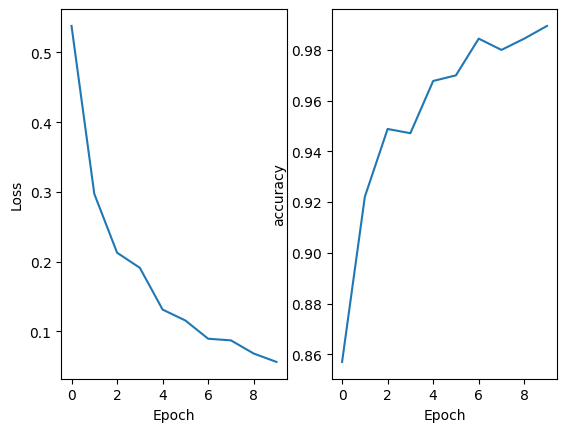

In [66]:
from torch import nn
from torch.nn import functional as F


class MLP(nn.Module):
  def __init__(self, input_size, hidden_size, nb_classes):
    super().__init__()  # Important! torch initializes a bunch of stuff with this line
    # FIXME
    self.fc1 = # Call Linear layer from pytorch
    self.fc2 = # Call Linear layer from pytorch

  def forward(self, x) -> torch.tensor:
    # FIXME
    # Make the forward layer
    # First fc1 then tanh then fc2
    return None


def compute_accuracy(y_pred, y_true):
  return torch.mean((y_pred == y_true).float())


model = MLP(X.shape[1], 50, len(torch.unique(Y)))
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

batch_size = 32
nb_epochs = 10

epochs, accuracies, losses = [], [], []

model.train()

for epoch in range(nb_epochs):
    for batch_index in range(0, len(X), batch_size):
        batch_X = X[batch_index:batch_index + batch_size]
        batch_Y = Y[batch_index:batch_index + batch_size]

        # Clear the previously accumulated gradients
        optimizer.zero_grad()

        logits = model(batch_X)
        loss = F.cross_entropy(logits.float(), batch_Y.to(torch.int64))  # Does implicitely softmax+CE
        loss.backward()

        # Apply a step of the optimizer, here gradient descent
        optimizer.step()


    model.eval()
    logits = model(X)
    loss = F.cross_entropy(logits.float(), Y.to(torch.int64))
    acc = compute_accuracy(logits.argmax(dim=1), Y)
    model.train()

    print(f"Epoch: {epoch}, loss: {loss}, accuracy: {acc}")
    epochs.append(epoch)
    losses.append(loss.detach())
    accuracies.append(acc)

plt.subplot(1, 2, 1)
plt.plot(epochs, losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies)
plt.xlabel("Epoch")
plt.ylabel("accuracy");

Try by yourself to extend this network and see the results:

- add more layers
- change the hidden dimension size
- change the non-linearity
- try different initializations

In [ ]:
# FIXME